In [1]:
!pip install keras

#Imports
import gym
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import tensorflow as tf
from tensorflow import keras
#from keras.models import Sequential
#from keras.layers import Dense
#from keras.optimizers import Adam
import random

#Create Gym
from gym import wrappers
envCartPole = gym.make('CartPole-v1')
envCartPole.seed(50) #Set the seed to keep the environment consistent across runs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/usr/local/lib/python3.7/dist-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym

[50]

In [2]:
tmp_array = []
for i in range(100):
    tmp_array.append(i)
    
#Add 10 to each element
for i in range(100):
    tmp_array[i] += 10
print(tmp_array)

[10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109]


In [3]:
tmp_array = []
for i in range(100):
    tmp_array.append(i)
    
#Add 10 to each element
tmp_array = np.array(tmp_array) + 10
print(tmp_array)

[ 10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  27
  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45
  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63
  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81
  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99
 100 101 102 103 104 105 106 107 108 109]


In [4]:
EPISODES = 500
TRAIN_END = 0

In [5]:
def discount_rate(): #Gamma
    return 0.95

def learning_rate(): #Alpha
    return 0.001

def batch_size(): #Size of the batch used in the experience replay
    return 24

In [7]:
class DeepQNetwork():
    def __init__(self, states, actions, alpha, gamma, epsilon,epsilon_min, epsilon_decay):
        self.nS = states
        self.nA = actions
        self.memory = deque([], maxlen=2500)
        self.alpha = alpha
        self.gamma = gamma
        #Explore/Exploit
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.model = self.build_model()
        self.loss = []
        
    def build_model(self):
        model = keras.Sequential() #linear stack of layers https://keras.io/models/sequential/
        model.add(keras.layers.Dense(24, input_dim=self.nS, activation='relu')) #[Input] -> Layer 1
        #   Dense: Densely connected layer https://keras.io/layers/core/
        #   24: Number of neurons
        #   input_dim: Number of input variables
        #   activation: Rectified Linear Unit (relu) ranges >= 0
        model.add(keras.layers.Dense(24, activation='relu')) #Layer 2 -> 3
        model.add(keras.layers.Dense(self.nA, activation='linear')) #Layer 3 -> [output]
        #   Size has to match the output (different actions)
        #   Linear activation on the last layer
        model.compile(loss='mean_squared_error', #Loss function: Mean Squared Error
                      optimizer=keras.optimizers.Adam(lr=self.alpha)) #Optimaizer: Adam (Feel free to check other options)
        return model

    def action(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.nA) #Explore
        action_vals = self.model.predict(state) #Exploit: Use the NN to predict the correct action from this state
        return np.argmax(action_vals[0])

    def test_action(self, state): #Exploit
        action_vals = self.model.predict(state)
        return np.argmax(action_vals[0])

    def store(self, state, action, reward, nstate, done):
        #Store the experience in memory
        self.memory.append( (state, action, reward, nstate, done) )
    def experience_replay(self, batch_size):
        #Execute the experience replay
        minibatch = random.sample( self.memory, batch_size ) #Randomly sample from memory

        #Convert to numpy for speed by vectorization
        x = []
        y = []
        np_array = np.array(minibatch)
        st = np.zeros((0,self.nS)) #States
        nst = np.zeros( (0,self.nS) )#Next States
        for i in range(len(np_array)): #Creating the state and next state np arrays
            st = np.append( st, np_array[i,0], axis=0)
            nst = np.append( nst, np_array[i,3], axis=0)
        st_predict = self.model.predict(st) #Here is the speedup! I can predict on the ENTIRE batch
        nst_predict = self.model.predict(nst)
        index = 0
        for state, action, reward, nstate, done in minibatch:
            x.append(state)
            #Predict from state
            nst_action_predict_model = nst_predict[index]
            if done == True: #Terminal: Just assign reward much like {* (not done) - QB[state][action]}
                target = reward
            else:   #Non terminal
                target = reward + self.gamma * np.amax(nst_action_predict_model)
            target_f = st_predict[index]
            target_f[action] = target
            y.append(target_f)
            index += 1
        #Reshape for Keras Fit
        x_reshape = np.array(x).reshape(batch_size,self.nS)
        y_reshape = np.array(y)
        epoch_count = 1 #Epochs is the number or iterations
        hist = self.model.fit(x_reshape, y_reshape, epochs=epoch_count, verbose=0)
        #Graph Losses
        for i in range(epoch_count):
            self.loss.append( hist.history['loss'][i] )
        #Decay Epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

In [8]:
nS = envCartPole.observation_space.shape[0] #This is only 4
nA = envCartPole.action_space.n #Actions
dqn = DeepQNetwork(nS, nA, learning_rate(), discount_rate(), 1, 0.001, 0.995 )

batch_size = batch_size()

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [9]:
rewards = [] #Store rewards for graphing
epsilons = [] # Store the Explore/Exploit
TEST_Episodes = 0
for e in range(EPISODES):
    state = envCartPole.reset()
    state = np.reshape(state, [1, nS]) # Resize to store in memory to pass to .predict
    tot_rewards = 0
    for time in range(210): #200 is when you "solve" the game. This can continue forever as far as I know
        action = dqn.action(state)
        nstate, reward, done, _ = envCartPole.step(action)
        nstate = np.reshape(nstate, [1, nS])
        tot_rewards += reward
        dqn.store(state, action, reward, nstate, done) # Resize to store in memory to pass to .predict
        state = nstate
        #done: CartPole fell. 
        #time == 209: CartPole stayed upright
        if done or time == 209:
            rewards.append(tot_rewards)
            epsilons.append(dqn.epsilon)
            print("episode: {}/{}, score: {}, e: {}"
                  .format(e, EPISODES, tot_rewards, dqn.epsilon))
            break
        #Experience Replay
        if len(dqn.memory) > batch_size:
            dqn.experience_replay(batch_size)
    #If our current NN passes we are done
    #I am going to use the last 5 runs
    if len(rewards) > 5 and np.average(rewards[-5:]) > 195:
        #Set the rest of the EPISODES for testing
        TEST_Episodes = EPISODES - e
        TRAIN_END = e
        break

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 23ms/step
episode: 70/500, score: 82.0, e: 0.0009954703940636294
1/1 [==============================] - 0s 19ms/step
episode: 71/500, score: 108.0, e: 0.0009954703940636294
1/1 [==============================] - 0s 23ms/step
episode: 72/500, score: 134.0, e: 0.0009954703940636294
1/1 [==============================] - 0s 17ms/step
episode: 73/500, score: 140.0, e: 0.0009954703940636294
1/1 [==============================] - 0s 29ms/step
episode: 74/500, score: 148.0, e: 0.0009954703940636294
1/1 [==============================] - 0s 18ms/step
episode: 75/500, score: 109.0, e: 0.0009954703940636294
1/1 [==============================] - 0s 21ms/step
episode: 76/500, score: 181.0, e: 0.0009954703940636294
1/1 [==============================] - 0s 23ms/step
episode: 77/500, score: 210.0, e: 0.0009954703940636294
1/1 [==============================] - 0s 21ms/step
episode: 78/500, score: 210.0, e: 

In [10]:
for e_test in range(TEST_Episodes):
    state = envCartPole.reset()
    state = np.reshape(state, [1, nS])
    tot_rewards = 0
    for t_test in range(210):
        action = dqn.test_action(state)
        nstate, reward, done, _ = envCartPole.step(action)
        nstate = np.reshape( nstate, [1, nS])
        tot_rewards += reward
        #DON'T STORE ANYTHING DURING TESTING
        state = nstate
        #done: CartPole fell. 
        #t_test == 209: CartPole stayed upright
        if done or t_test == 209: 
            rewards.append(tot_rewards)
            epsilons.append(0) #We are doing full exploit
            print("episode: {}/{}, score: {}, e: {}"
                  .format(e_test, TEST_Episodes, tot_rewards, 0))
            break;

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 26ms/step
episode: 395/420, score: 210.0, e: 0
1/1 [==============================] - 0s 28ms/step
episode: 396/420, score: 210.0, e: 0
1/1 [==============================] - 0s 26ms/step
episode: 397/420, score: 188.0, e: 0
1/1 [==============================] - 0s 26ms/step
episode: 398/420, score: 210.0, e: 0
1/1 [==============================] - 0s 32ms/step
episode: 399/420, score: 210.0, e: 0
1/1 [==============================] - 0s 30ms/step
episode: 400/420, score: 210.0, e: 0
1/1 [==============================] - 0s 30ms/step
episode: 401/420, score: 210.0, e: 0
1/1 [==============================] - 0s 28ms/step
episode: 402/420, score: 210.0, e: 0
1/1 [==============================] - 0s 25ms/step
episode: 403/420, score: 210.0, e: 0
1/1 [==============================] - 0s 28ms/step
episode: 404/420, score: 210.0, e: 0
1/1 [==============================] - 0s 26ms/step
episode

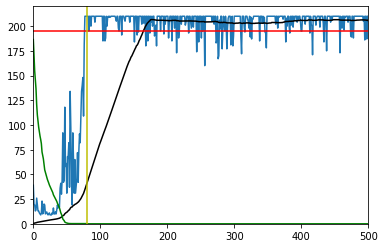

In [11]:
rolling_average = np.convolve(rewards, np.ones(100)/100)
plt.plot(rewards)0.233
plt.plot(rolling_average, color='black')
plt.axhline(y=195, color='r', linestyle='-') #Solved Line
#Scale Epsilon (0.001 - 1.0) to match reward (0 - 200) range
eps_graph = [200*x for x in epsilons]
plt.plot(eps_graph, color='g', linestyle='-')
#Plot the line where TESTING begins
plt.axvline(x=TRAIN_END, color='y', linestyle='-')
plt.xlim( (0,EPISODES) )
plt.ylim( (0,220) )
plt.show()
envCartPole.close()